In [71]:
import numpy as np
from scipy import misc
from skimage.transform import resize
from sklearn import metrics

from keras_wrapper.cnn_model import saveModel, loadModel
from keras_wrapper.dataset import Dataset, saveDataset, loadDataset

from gap_model import GAP_Model

# Plot libraries
import matplotlib as mpl
mpl.use('Agg') # run matplotlib without X server (GUI)
import matplotlib.pyplot as plt
%matplotlib inline

# Parameters
set_name = 'val'
questions_per_img = 3
data_path = '/media/HDD_2TB/DATASETS/VQA/'
questions_path = 'Questions/OpenEnded_mscoco_val2014_questions.txt'
dataset_name = 'VQA_GAP'
#CAM_network_path = 'trained_models/VGG_GAP_Network_preGAP/'
CAM_network_path = 'trained_models/VGG_GAP_Network_GAP/'
CAM_network_epoch = 3 # preGAP 14

set_CAM_layer = True

n_show = 6 # number of images to show at once

In [86]:
# Plot data function
cmap = plt.get_cmap('jet') # set colormap
def plot_data(images_path, imgs, questions, labels_GT, 
              labels_pred=None, imgs_heatmaps=None, word2idx=None, heatmaps_type='GT', col_size=7, row_size=4, per_row=3):
    
    num_show = len(imgs)

    if(imgs_heatmaps is None or word2idx is None):
        n_rows = int(np.ceil(num_show/per_row))
    else:
        n_rows = num_show
        
    f = plt.figure(1)
    f.set_size_inches(col_size*n_rows, row_size*per_row)
    for c in range(num_show):
        im = imgs[c]
        im = misc.imread(images_path+'/'+im)
        
        # Use heatmaps
        if(imgs_heatmaps is not None and word2idx is not None):
            reshape_size = im.shape
            if heatmaps_type == 'GT':
                labels_show = labels_GT
            elif heatmaps_type == 'pred':
                labels_show = labels_pred
            else:
                raise Exception()
            
            max_lab = min(per_row, len(labels_show[c]))
            for ilab,lab in enumerate(labels_show[c][:max_lab]):
                lab = word2idx[lab]
                # heatmap 0-1 normalization
                norm = (imgs_heatmaps[c][lab] - np.min(imgs_heatmaps[c][lab]))
                norm = norm / (np.max(imgs_heatmaps[c][lab]) - np.min(imgs_heatmaps[c][lab]))
                heat = cmap(norm) # apply colormap
                heat = np.delete(heat, 3, 2) # ???
                heat = np.array(heat[:, :, :3]*255, dtype=np.uint8)
                # combine original image with heatmap
                heat = np.array(resize(heat, reshape_size, order=1, preserve_range=True), dtype=np.uint8)
                im_combined = np.array(im*0.5 + heat*0.5, dtype=np.uint8)
        
                ax = plt.subplot(n_rows,per_row,c*per_row+ilab+1)# select image position in grid
            
                plt.imshow(im_combined)
                plt.gca().xaxis.set_major_locator(plt.NullLocator())
                plt.gca().yaxis.set_major_locator(plt.NullLocator())

                text = ''
                text += 'I: %s\n' % imgs[c]
                text += 'L '+heatmaps_type+': %s\n' % str(labels_show[c][ilab])
                text += '\n'
                plt.xlabel(text, fontsize=14)
                
        # Don't use heatmaps
        else:
            ax = plt.subplot(n_rows,per_row,c+1) # select image position in grid
            
            plt.imshow(im)
            plt.gca().xaxis.set_major_locator(plt.NullLocator())
            plt.gca().yaxis.set_major_locator(plt.NullLocator())

            text = ''
            text += 'I: %s\n' % imgs[c]
            for i, q in enumerate(questions[c]):
                text += 'Q%d: %s\n' % (i+1,q)
            text += 'L GT: %s\n' % str(labels_GT[c])
            if labels_pred is not None:
                text += 'L pred: %s\n' % str(labels_pred[c])
            text += '\n'
            plt.xlabel(text, fontsize=14)

## Data visualization

In [47]:
# Load dataset (this may take ~4 minutes...)
ds = loadDataset(data_path+'Dataset_'+dataset_name+'.pkl')

In [87]:
# Get some samples
#ds.resetCounters() # uncomment this instruction for start reading images from index=0
exec('n_samples = ds.len_'+set_name)
[X, Y, [new_last,last,surpassed]] = ds.getXY(set_name, n_show, dataAugmentation=False, debug=True)

In [88]:
###### Retrieve chosen triplets (img, qst, labels)

# images
images = X[0]

# labels
idx2words = ds.extra_variables['idx2word_binary']
labels = [[idx2words[e] for e in np.where(Y[0][i] == 1)[0]] for i in range(n_show)]

# questions
questions = []
if(surpassed):
    img_indices = range(last,n_samples) + range(new_last)
else:
    img_indices = range(last, new_last)
with open(data_path+'/'+questions_path) as f:
    f = f.read().split('\n')
    for ind in img_indices:
        questions.append([])
        for qi in range(questions_per_img):
            questions[-1].append(f[ind*questions_per_img + qi])

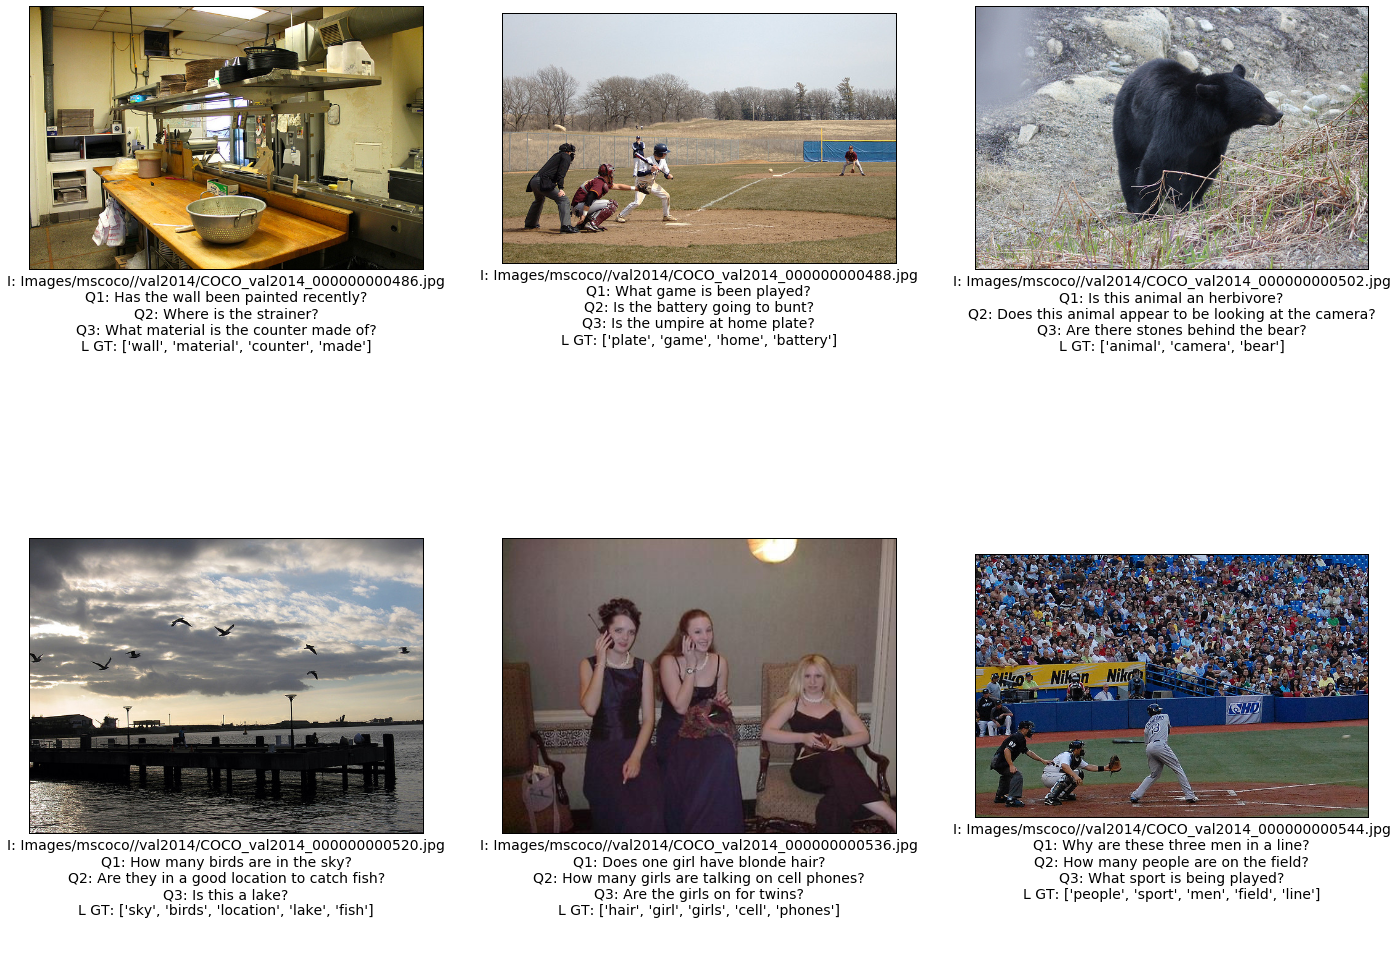

In [89]:
# Plot images without predictions
plot_data(data_path, images, questions, labels, col_size=12, row_size=6)

## Model results visualization

In [73]:
# Load CAM network
net = loadModel(CAM_network_path, CAM_network_epoch)

if set_CAM_layer:
    net.setCAMLayer(input_layers=['image'], output_CAM_name='CAM',
                        gap_classifier_name='qst_vocab')

-----------------------------------------------------------------------------------
		GAP_Model instance
-----------------------------------------------------------------------------------
_model_type: VGG_16_FunctionalAPI
name: VGG_GAP_Network
model_path: trained_models/VGG_GAP_Network_GAP
verbose: 1

MODEL PARAMETERS:
{'TOKENIZATION_METHOD': 'tokenize_questions', 'STORE_PATH_CAM': 'trained_models/VGG_GAP_Network_CAM', 'SEQ_TO_FUNCTIONAL': True, 'START_EVAL_ON_EPOCH': 1, 'RELOAD_GAP': 0, 'MODEL_WEIGHTS': '/media/HDD_2TB/CNN_MODELS/VGG/vgg16_weights.h5', 'MODEL_NAME': 'VGG_GAP_Network', 'BATCH_SIZE': 64, 'MODEL_TYPE': 'VGG_16_FunctionalAPI', 'MEAN_SUBSTRACTION': True, 'REBUILD_DATASET': False, 'IMG_SIZE': [256, 256, 3], 'OPTIMIZER': 'adam', 'QUESTIONS_VOCABULARY': 1000, 'EPOCHS_FOR_SAVE': 1, 'NEW_LAST_LR_MULTIPLIER': 10.0, 'MEAN_IMAGE': [122.6795, 116.669, 104.0067], 'METRICS': ['multiclass'], 'FIRST_GAP_LAYER_NAME': 'conv5-3', 'LR': 0.0001, 'MODE': 'training', 'CLASSIFIER_ACTIVATION':

In [90]:
# Load images
if surpassed:
    X1 = ds.getX(set_name, last, n_samples, dataAugmentation=False)
    X2 = ds.getX(set_name, 0, new_last, dataAugmentation=False)
    X = []
    for x1,x2 in zip(X1,X2):
        X.append(x1+x2)
else:
    X = ds.getX(set_name, last, new_last, dataAugmentation=False)

# Predict
predictions = net.predictOnBatch(X)

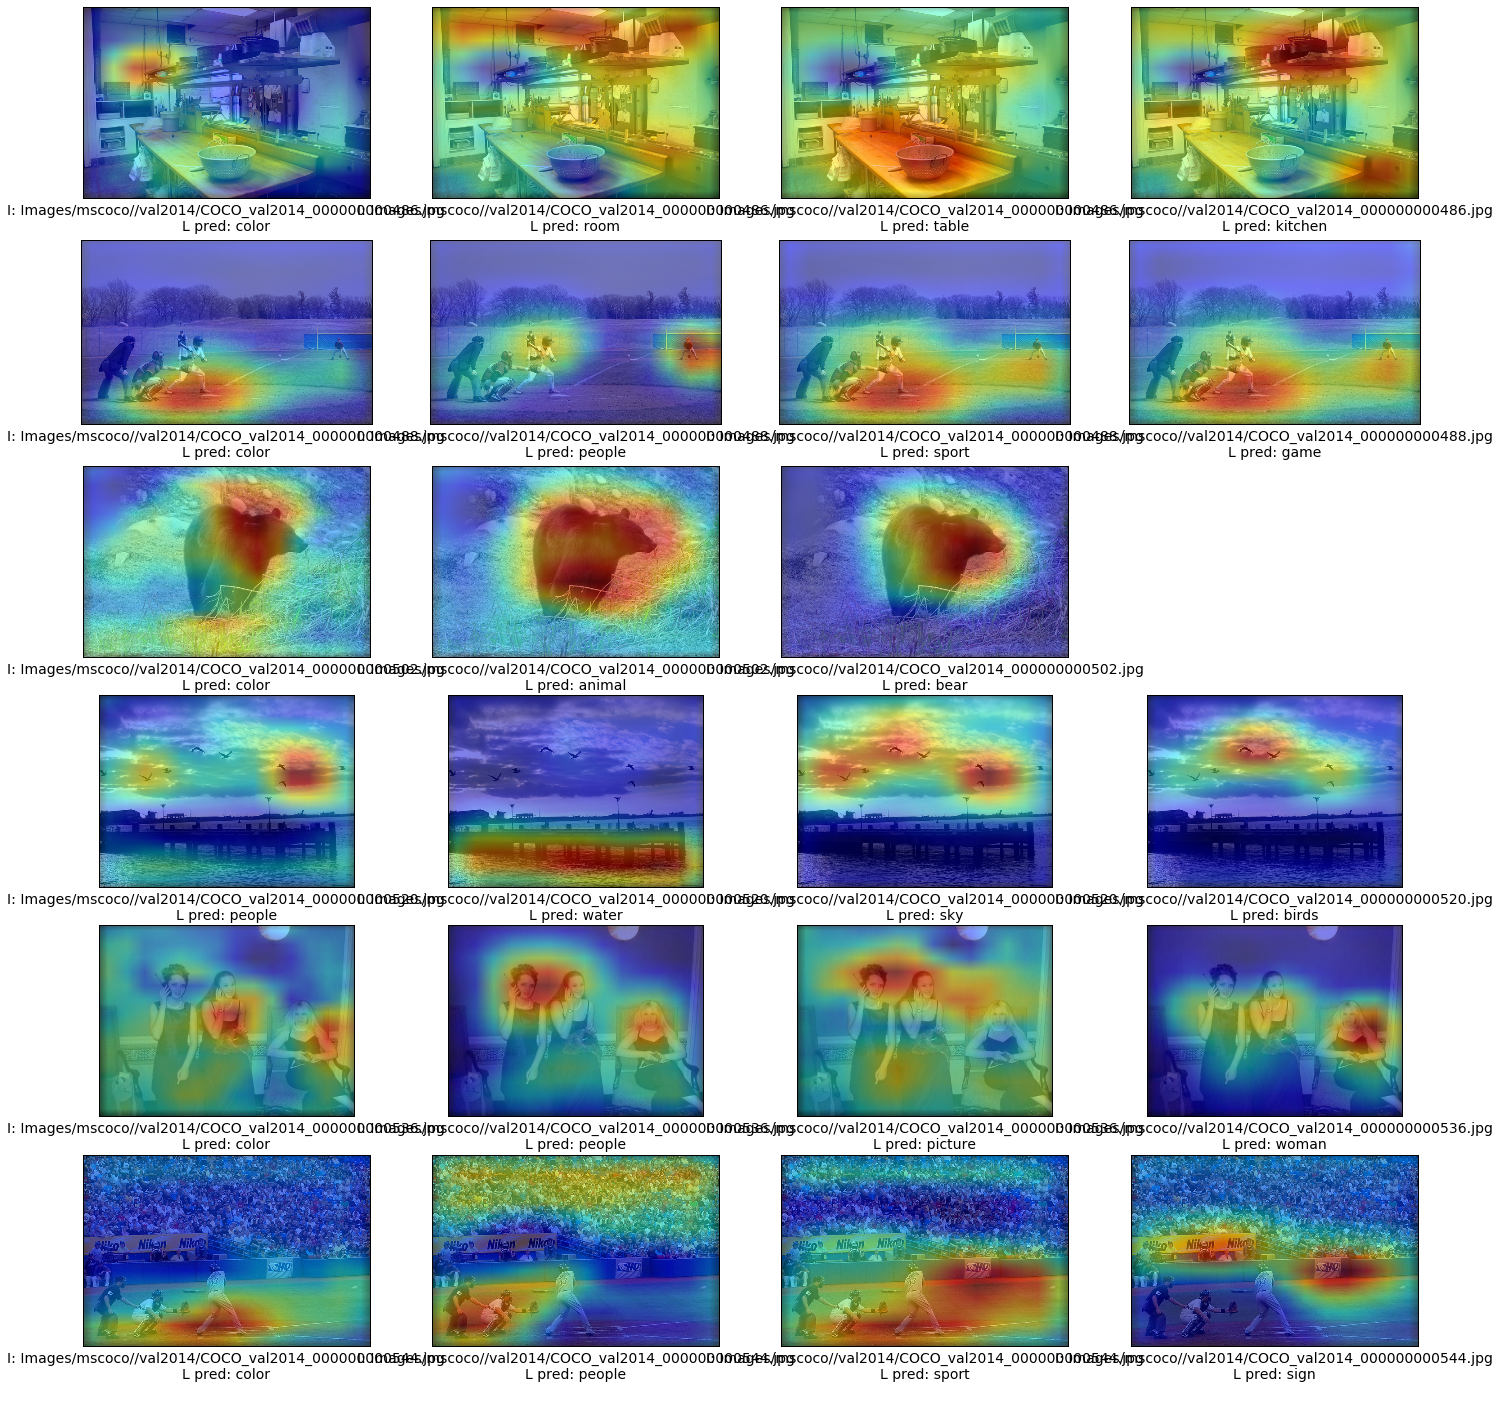

In [95]:
# Format predictions
if(len(predictions) == 2):
    labels_pred = np.where(predictions[0] > 0.5, 1, 0)
    CAMs_pred = predictions[1]
    per_row=4
    col_size=4
    row_size=6
else:
    labels_pred = np.where(predictions > 0.5, 1, 0)
    CAMs_pred = None
    per_row=3
    col_size=12
    row_size=6

# Show result
idx2words = ds.extra_variables['idx2word_binary']
labels_pred = [[idx2words[e] for e in np.where(labels_pred[i] == 1)[0]] for i in range(n_show)]
plot_data(data_path, images, questions, labels, labels_pred=labels_pred, imgs_heatmaps=CAMs_pred, heatmaps_type='pred', 
          word2idx=ds.extra_variables['word2idx_binary'], col_size=col_size, row_size=row_size, per_row=per_row)

In [125]:
n_samples = 50

# Compute scores on first n_samples
ds.resetCounters() # uncomment this instruction for start reading images from index=0
[X_, Y_] = ds.getXY(set_name, n_samples, dataAugmentation=False)
predictions_ = net.predictOnBatch(X_)

y_gt = np.array(Y_[0])
y_pred = np.array(predictions_[0])

# Compute Coverage Error
coverr = sklearn.metrics.coverage_error(y_gt, y_pred)
# Compute Label Ranking AvgPrec
avgprec = sklearn.metrics.label_ranking_average_precision_score(y_gt, y_pred)
# Compute Label Ranking Loss
rankloss = sklearn.metrics.label_ranking_loss(y_gt, y_pred)

print 'Coverage Rrror (best: avg labels per sample = %f): %f' % (np.sum(y_gt)/float(n_samples), coverr)
print 'Label Ranking Average Precision (best: 1.0): %f' % avgprec
print 'Label Ranking Loss (best: 0.0): %f' % rankloss

Coverage Rrror (best: avg labels per sample = 6.860000): 476.200000
Label Ranking Average Precision (best: 1.0): 0.103729
Label Ranking Loss (best: 0.0): 0.161748
